## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
#binary_dirs = 'binaries_model1/'
binary_dirs = 'binaries_model4/'

How do we want to quantify how well we are doing?

In [2]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [3]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [4]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)

Final box analytics:

In [5]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)

In [6]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [7]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


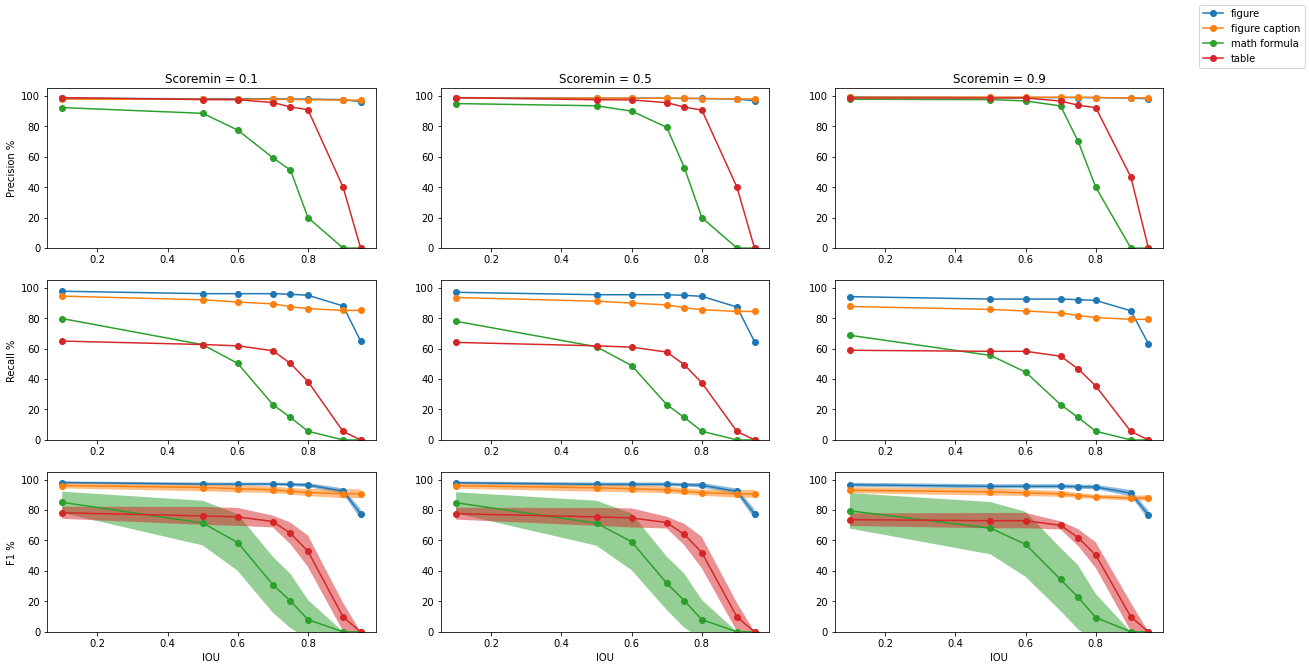

In [8]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [9]:
scoremin = 0.1 

What IOU cut-offs for each label? for reference:

In [10]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [11]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.8] # fig, fig+caption, math formula, table

In [12]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [13]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [14]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              87.9%           85.0%           6.1%            36.6%          
FP              2.4%            2.6%            16.7%           3.6%           
FN              12.1%           15.0%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.3+/-1.5%     96.9+/-2.1%     28.4+/-37.0%    91.3+/-7.7%    
Recall          88.1+/-2.3%     84.9+/-2.3%     8.9+/-9.8%      37.2+/-7.4%    
F1              92.4+/-0.7%     90.5+/-2.1%     13.0+/-15.0%    52.6+/-8.2%    


## Vs. Time
Also, let's plot metrics vs. year.

In [15]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [16]:
df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)

In [17]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1898-01-01,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1907-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1908-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1909-01-01,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1913-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
sampleHist = '10Y' # 5 years

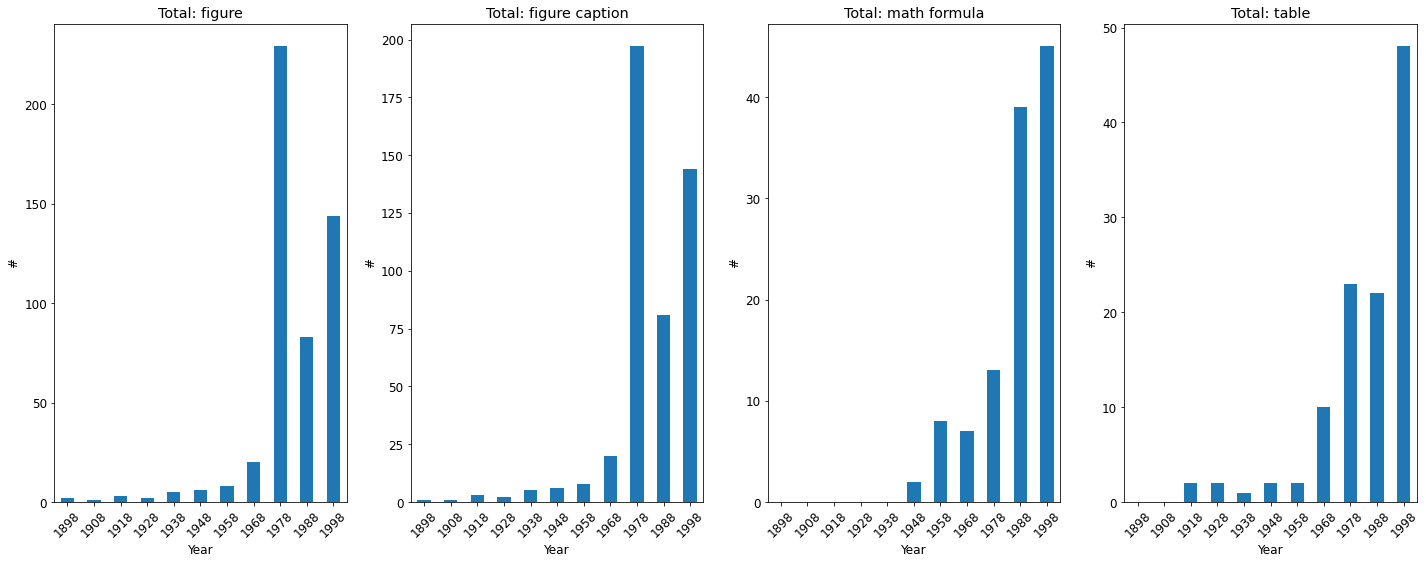

In [19]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

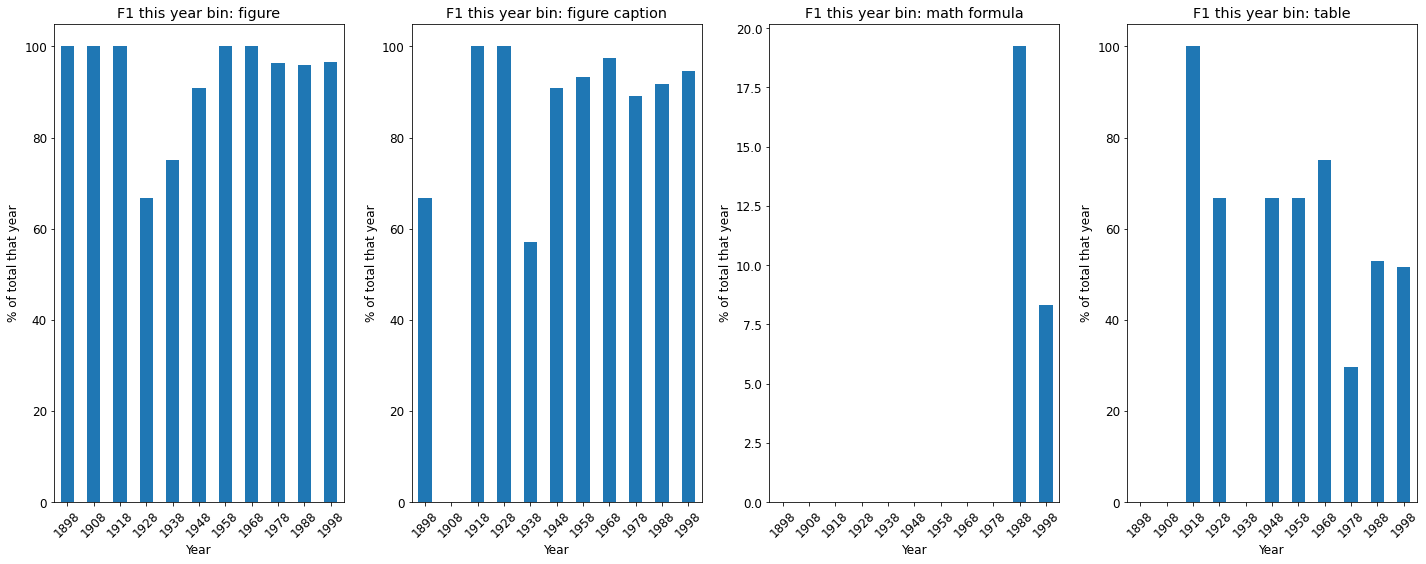

In [20]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Some other metrics:

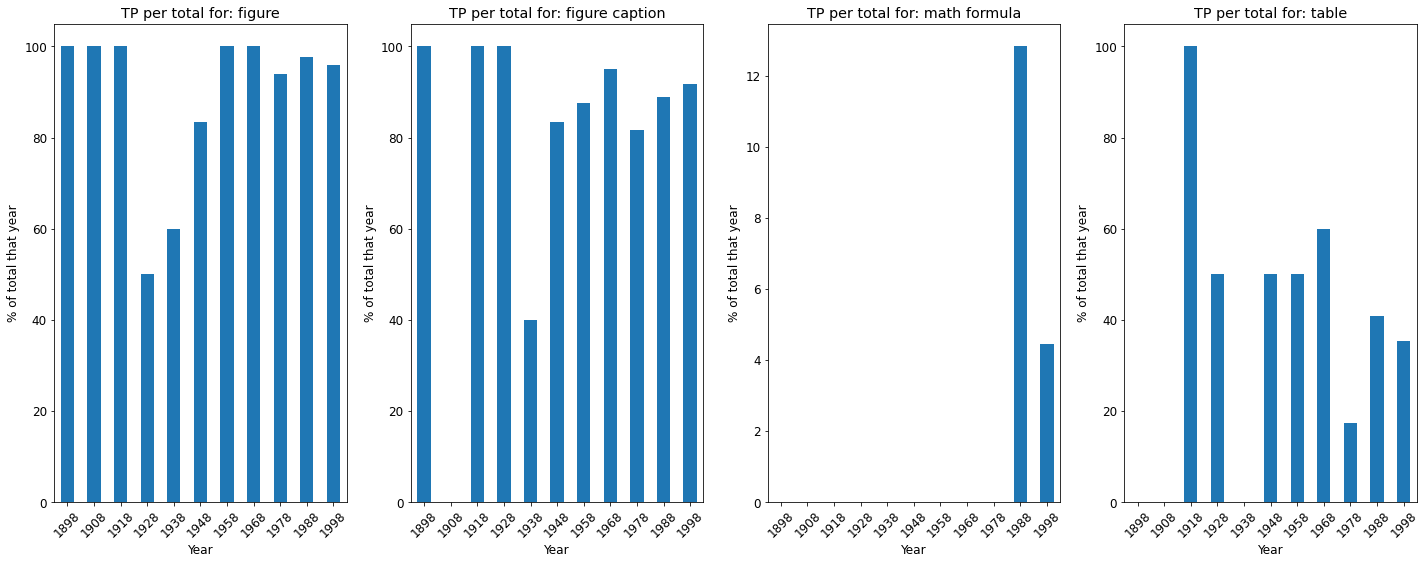

In [21]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


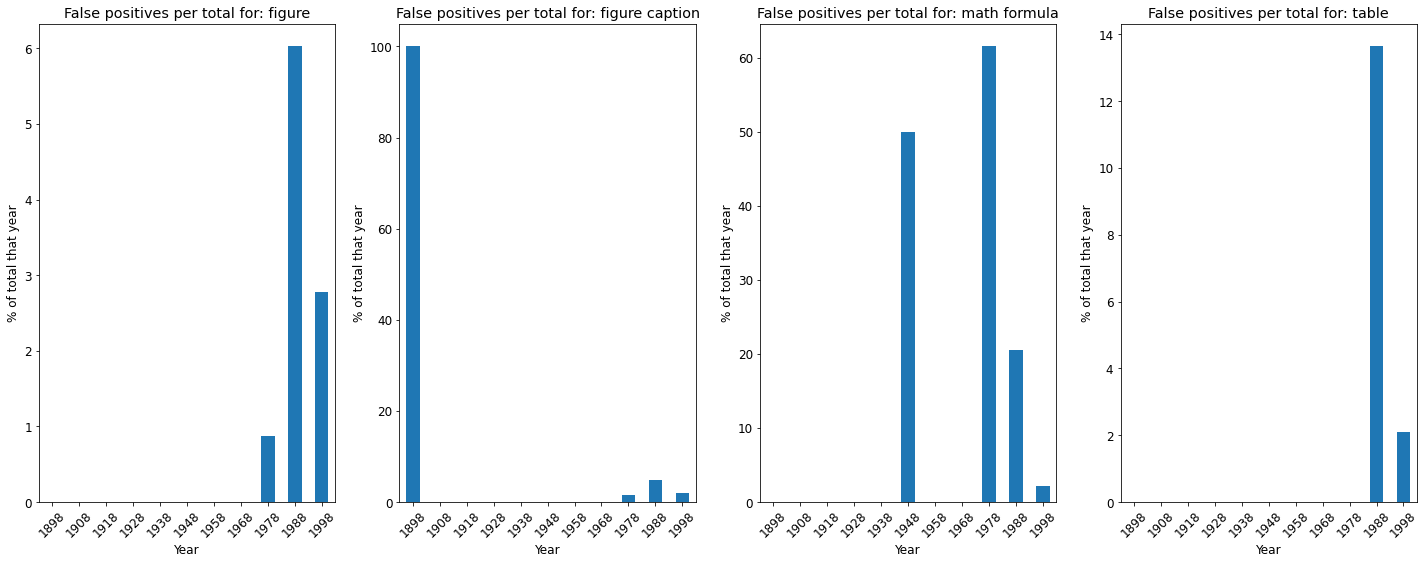

In [22]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

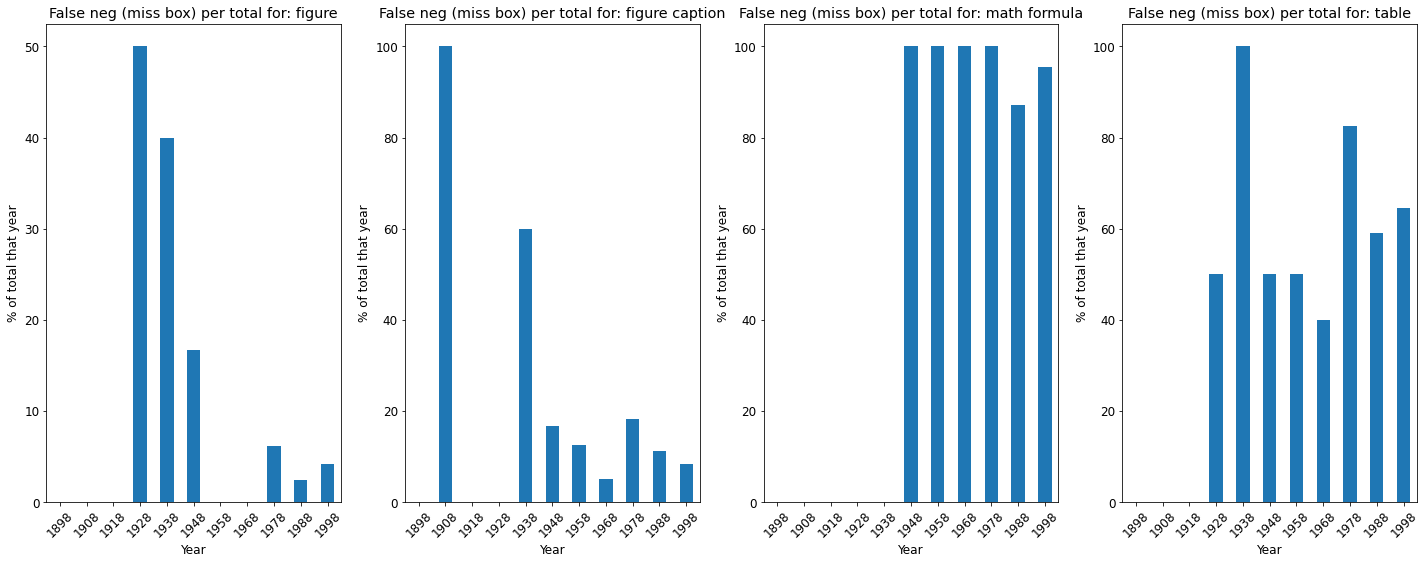

In [23]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

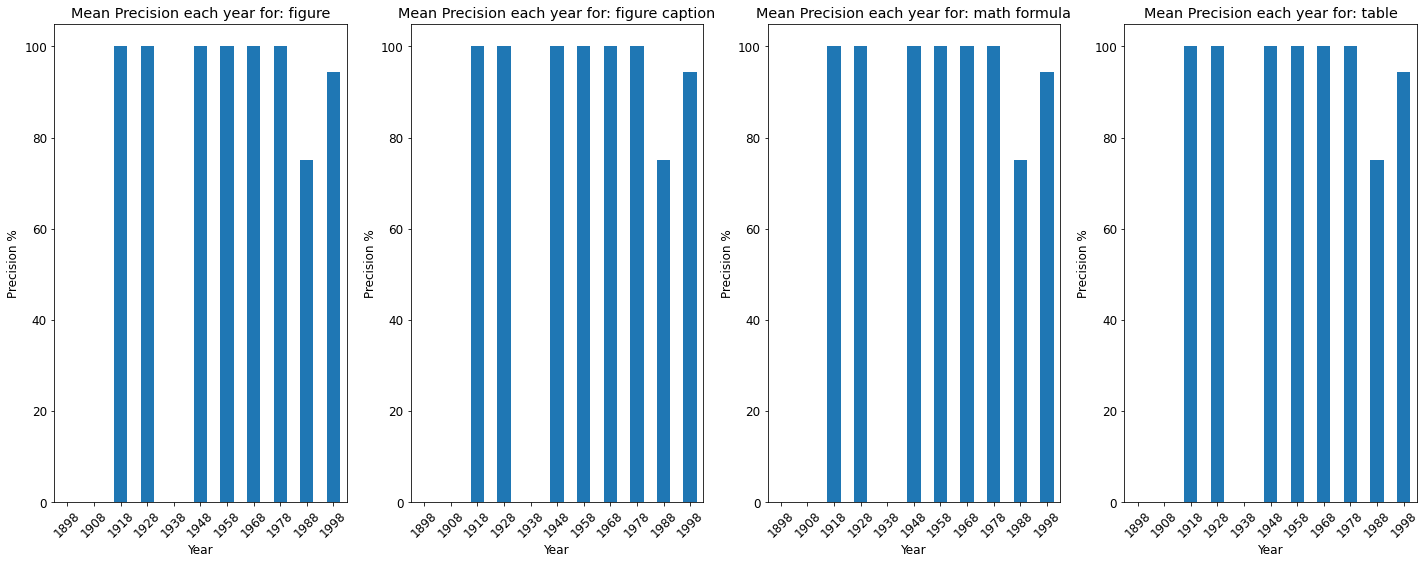

In [24]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

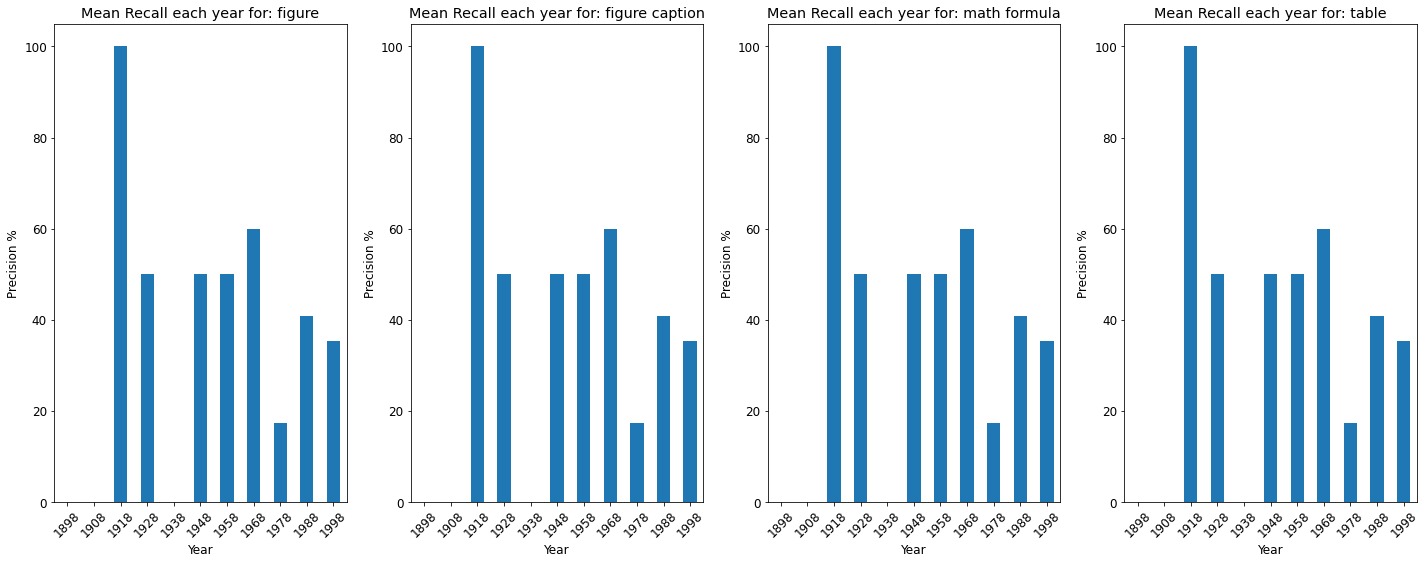

In [25]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

# Other steps of the post processing process

## 1. Raw-ish boxes

These have been cleaned for overlapping boxes -- only the higher score ones are taken if there is a large overlap.

Final metrics:

In [26]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox,sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [27]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              60.2%           0.6%            6.1%            36.6%          
FP              4.2%            7.9%            16.7%           3.6%           
FN              39.8%           99.4%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       93.5+/-1.9%     11.2+/-10.2%    11.1+/-14.1%    91.0+/-11.1%   
Recall          60.5+/-3.1%     0.6+/-0.5%      4.3+/-5.8%      34.2+/-14.9%   
F1              73.4+/-2.5%     1.1+/-0.9%      6.2+/-8.2%      47.7+/-16.7%   


IOU=0.6

In [28]:
#ioumin_per_label2 = [0.6,0.6,0.6,0.6]

ioumin_per_label2 = [0.8,0.8,0.8,0.8]

In [29]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           35.9%           6.1%            36.6%          
FP              2.2%            6.2%            16.7%           3.6%           
FN              10.1%           64.1%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.5%     84.8+/-9.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-4.4%     35.6+/-4.3%     4.3+/-5.8%      34.2+/-14.9%   
F1              93.6+/-2.6%     50.0+/-5.4%     6.2+/-8.2%      47.7+/-16.7%   


Plot vs IOU:

In [ ]:
iouvec = [0.05, 0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95]
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## 2. Merge with PDF results

If any pdffigures2 results -- get these.

In [ ]:
#boxes_pdf, labels_pdf, scores_pdf
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_pdf, labels_pdf, scores_pdf,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_pdf, labels_pdf, scores_pdf,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Merge with Heuristics

If there are also heurstically found figure captions -- overlap these boxes.

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_heur, labels_heur, scores_heur,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_heur, labels_heur, scores_heur,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Add in Heuristic Captions

If there are figures without captions, look for heurstically determined captions.

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_heur2, labels_heur2, scores_heur2,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_heur2, labels_heur2, scores_heur2,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand by paragraphs and words

### 1. Found boxes

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. Expand trues as well -- this is technically already done in annotations? or no?

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Merge with Image Processing Squares

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq1, labels_sq1, scores_sq1,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq1, labels_sq1, scores_sq1,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Drop any very large captions

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq2, labels_sq2, scores_sq2,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq2, labels_sq2, scores_sq2,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Take out caption overlap with fig boxes -- why does this go back to table/math formula levels from before?

### 1. Found boxes

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. True boxes

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand again for some reason??

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq4, labels_sq4, scores_sq4,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq4, labels_sq4, scores_sq4,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand Area Above Captions

### 1. Found boxes

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. True Boxes

In [ ]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox3,boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

In [ ]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox3,
                                              boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

In [ ]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Plot how metrics change with steps

In [ ]:
iouvec2 = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

In [ ]:
# trueboxes = [truebox,truebox,truebox,truebox,truebox,truebox1,truebox1,
#              truebox1,truebox1,truebox2,truebox2,truebox2,truebox3]
# foundboxes = [sboxes_cleaned,boxes_pdf,boxes_heur,boxes_heur2,boxes_par_found,
#               boxes_par_found,boxes_sq1,boxes_sq2,boxes_sq3,boxes_sq3,boxes_sq4,boxes_sq5,boxes_sq5]
# foundlabels=[slabels_cleaned,labels_pdf,labels_heur,labels_heur2,labels_par_found,labels_par_found,
#              labels_sq1,labels_sq2,labels_sq3,labels_sq3,labels_sq4,labels_sq5,labels_sq5]
# foundscores=[sscores_cleaned,scores_pdf,scores_heur,scores_heur2,scores_par_found,scores_par_found,
#              scores_sq1,scores_sq2,scores_sq3,scores_sq3,scores_sq4,scores_sq5,scores_sq5]


# # actual things
# trueboxes = [truebox, #1
#              truebox, #2
#              truebox, #3
#              truebox, #4
#              truebox1, #5
#              truebox1, #6
#              truebox2, #7
#              truebox3] #8
# foundboxes = [sboxes_cleaned, #1
#               boxes_pdf, #2
#               boxes_heur, #3
#               boxes_heur2, #4 --
#               boxes_sq1, #5
#               boxes_sq2, #6 --
#               boxes_sq4, #7
#               boxes_sq5] #8
# foundlabels=[slabels_cleaned,labels_pdf,labels_heur,labels_heur2,labels_sq1,labels_sq2,labels_sq4,labels_sq5]
# foundscores=[sscores_cleaned,scores_pdf,scores_heur,scores_heur2,scores_sq1,scores_sq2,scores_sq4,scores_sq5]


# paper order?
trueboxes = [truebox, #1
             truebox, #2
             truebox, #3
             truebox, #4
             truebox]#, #4
             # truebox1, #5
             # truebox1, #6
             # truebox2, #7
             # truebox3] #8
foundboxes = [boxes1,
              sboxes_cleaned, #1
              boxes_pdf, #2
              boxes_heur,
              boxes_heur2]#, #3
              # boxes_par_found, 
              # boxes_sq2, #6 --
              # boxes_sq4, #7
              # boxes_sq5] #8
foundlabels=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            labels_heur2]#,
             # labels_par_found,
             # labels_sq2,
             # labels_sq4,
             # labels_sq5]
foundscores=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            scores_heur2]#,
             # scores_par_found,
             # scores_sq2,
             # scores_sq4,
             # scores_sq5]

In [ ]:
len(trueboxes), len(foundboxes), len(foundlabels), len(foundscores)

In [ ]:
#precsave[0]

In [ ]:
precsave = []; recsave = []; f1save = []
TPsave = []; FPsave = []; FNsave = []

for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
    TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouvec2,
                                                  t,fb, fl, fs,n_folds_cv=n_folds_cv,seed=5)
    # combo metrics
    precisions, precision_stds, recalls, \
      recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                                   LABELS,[scoremin],
                                                   iouvec2)

    TPsave.append(TPs[:,0,:].sum(axis=-1)); FPsave.append(FPs[:,0,:].sum(axis=-1)); FNsave.append(FNs[:,0,:].sum(axis=-1))
    precsave.append(precisions[:,0,:]); recsave.append(recalls[:,0,:]); f1save.append(f1s[:,0,:])
    #import sys; sys.exit()

In [ ]:
#labels1
np.array(TPsave).shape, TPs.shape

In [ ]:
n = len(foundboxes)+3
colors = plt.cm.jet(np.linspace(0,1,n))
ylabels = ['TP','FP','FN','Precision', 'Recall', 'F1']

In [ ]:
lw=5
fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))

for ip,(p,r,f,tp,fp,fn) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave)):
    lwh=lw
    #lwh=5
    if ip==3: lwh=10
    #lwh = 8-ip
    for il in range(len(LABELS[:2])):
        ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
        ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
        ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
        if il == 0:
            ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
        else:
            ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
        ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
        ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')

fig.legend(loc='center right')
plt.show()

In [ ]:
# plot ratio of last 2 changes
fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
lwh=5
for il in range(len(LABELS[:2])):
    ax[0][il].plot(iouvec2, precsave[-1][il]/precsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[1][il].plot(iouvec2, recsave[-1][il]/recsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[2][il].plot(iouvec2, f1save[-1][il]/f1save[-2][il]-1,color=colors[ip],lw=lwh)
    ax[3][il].plot(iouvec2, TPsave[-1][il]/TPsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[4][il].plot(iouvec2, FPsave[-1][il]/FPsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[5][il].plot(iouvec2, FNsave[-1][il]/FNsave[-2][il]-1,color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')

plt.show()

In [ ]:
#imgs_name